In [25]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
import time 
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)


<module 'helper' from '../src\\helper.py'>

In [57]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/all_data_batches1-9.csv"
data = pd.read_csv(datafilename)

print(data.columns.values[:10])

#get area columns
areaCols = data.columns.values[7:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information

batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

def labeler(name):
    if "NIST" in name and "splash" not in name and ("NIST1950_1" in name or "NIST1950-1" in name):
        return 0
    if "WU350" in name:
        return 1 
    if "Blank" in name:
        return 2
    else:
        return -1
samp_type = [labeler(x) for x in areaCols]

goodInd = [x for x in range(len(samp_type)) if samp_type[x] >= 0 ]

samp_type = np.array(samp_type)[goodInd]
areaData = areaData[goodInd]
batchInfo = np.array(batchInfo)[goodInd]

print(len(areaData))

['Compound Name' 'Compound Group' 'Chromatography-ion mode' 'Formula'
 'Mass' 'RT' 'CAS ID' 'B1_pBlank_1' 'B1_pBlank_2' 'B1_pBlank_3']
757


535199


No handles with labels found to put in legend.


158


Text(0, 0.5, 'PC2')

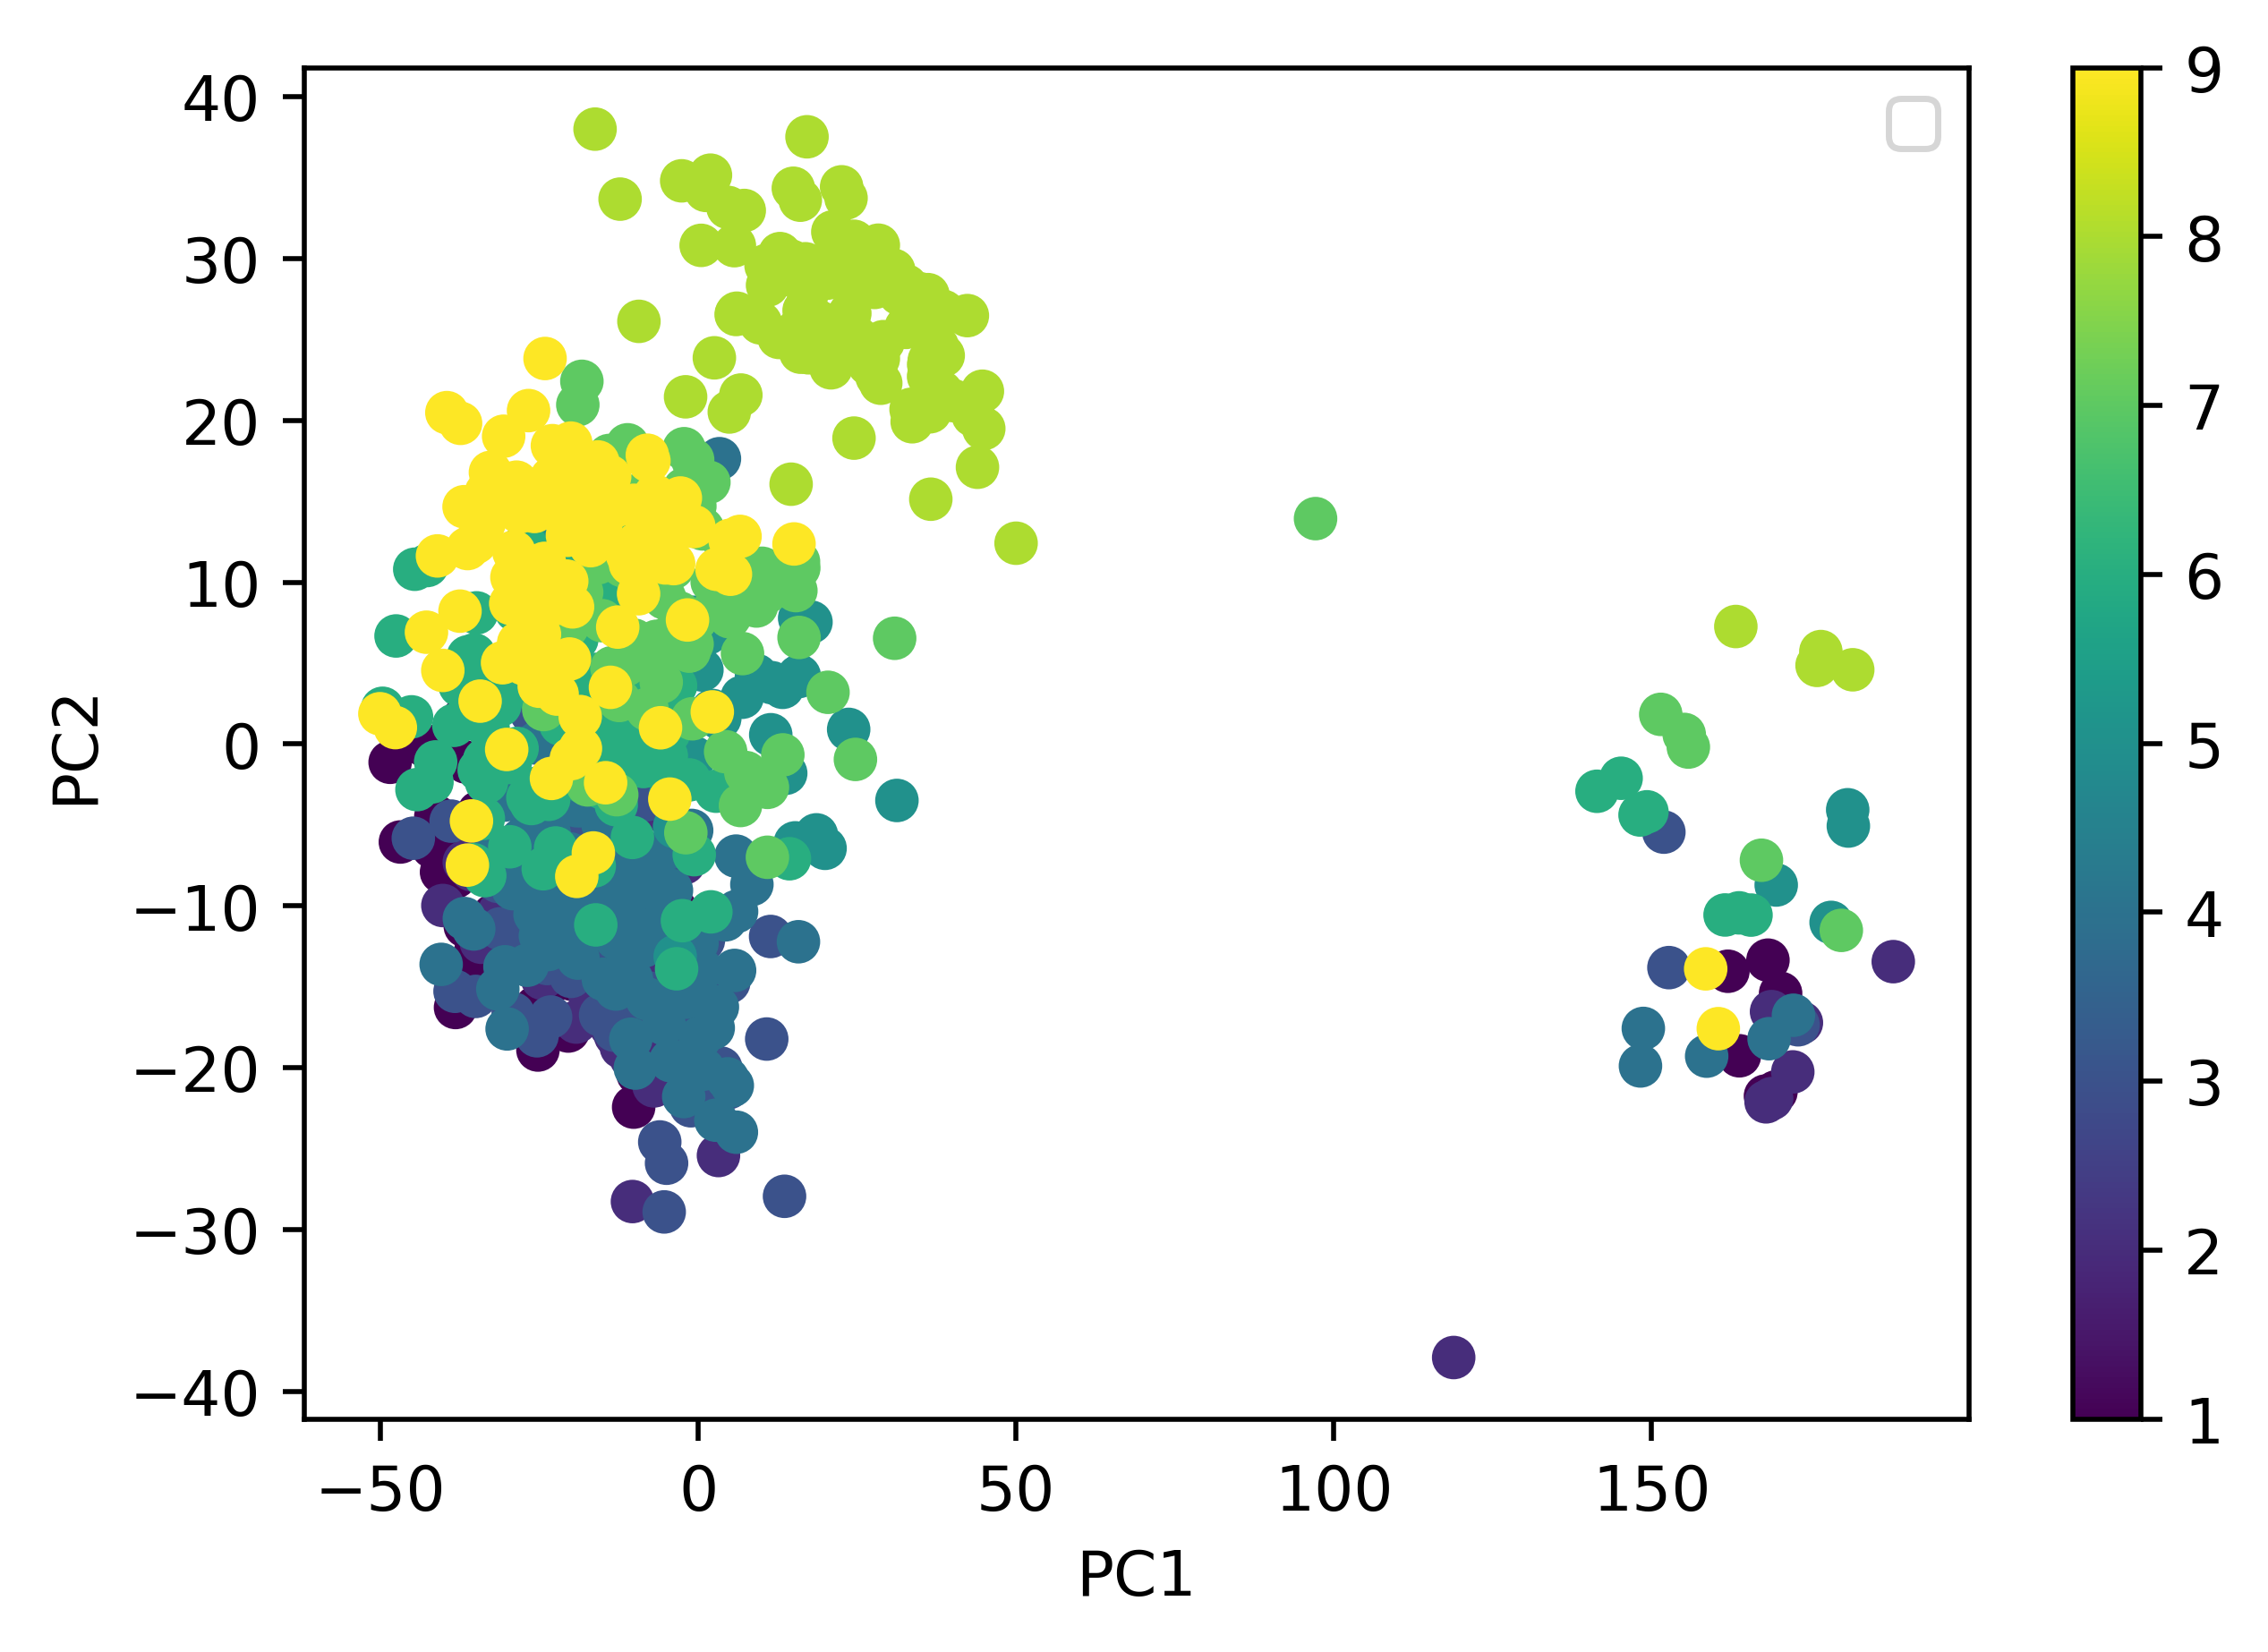

In [58]:
#visualize complete dataset

#first impute dataset
d_whole = areaData
d_whole_imput = helper.imputeRowMin(d_whole)

#log2 normalize
d_whole_imput = np.log2(d_whole_imput) 

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_imput)
loads = pca.transform(d_whole_imput)

#make pca plot by batch
plt.figure()
batch_con = batchInfo
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")


0.02 20 687
0.05 417 270
0.1 179 91
0.15 76 15
707


Text(0, 0.5, '# of compounds')

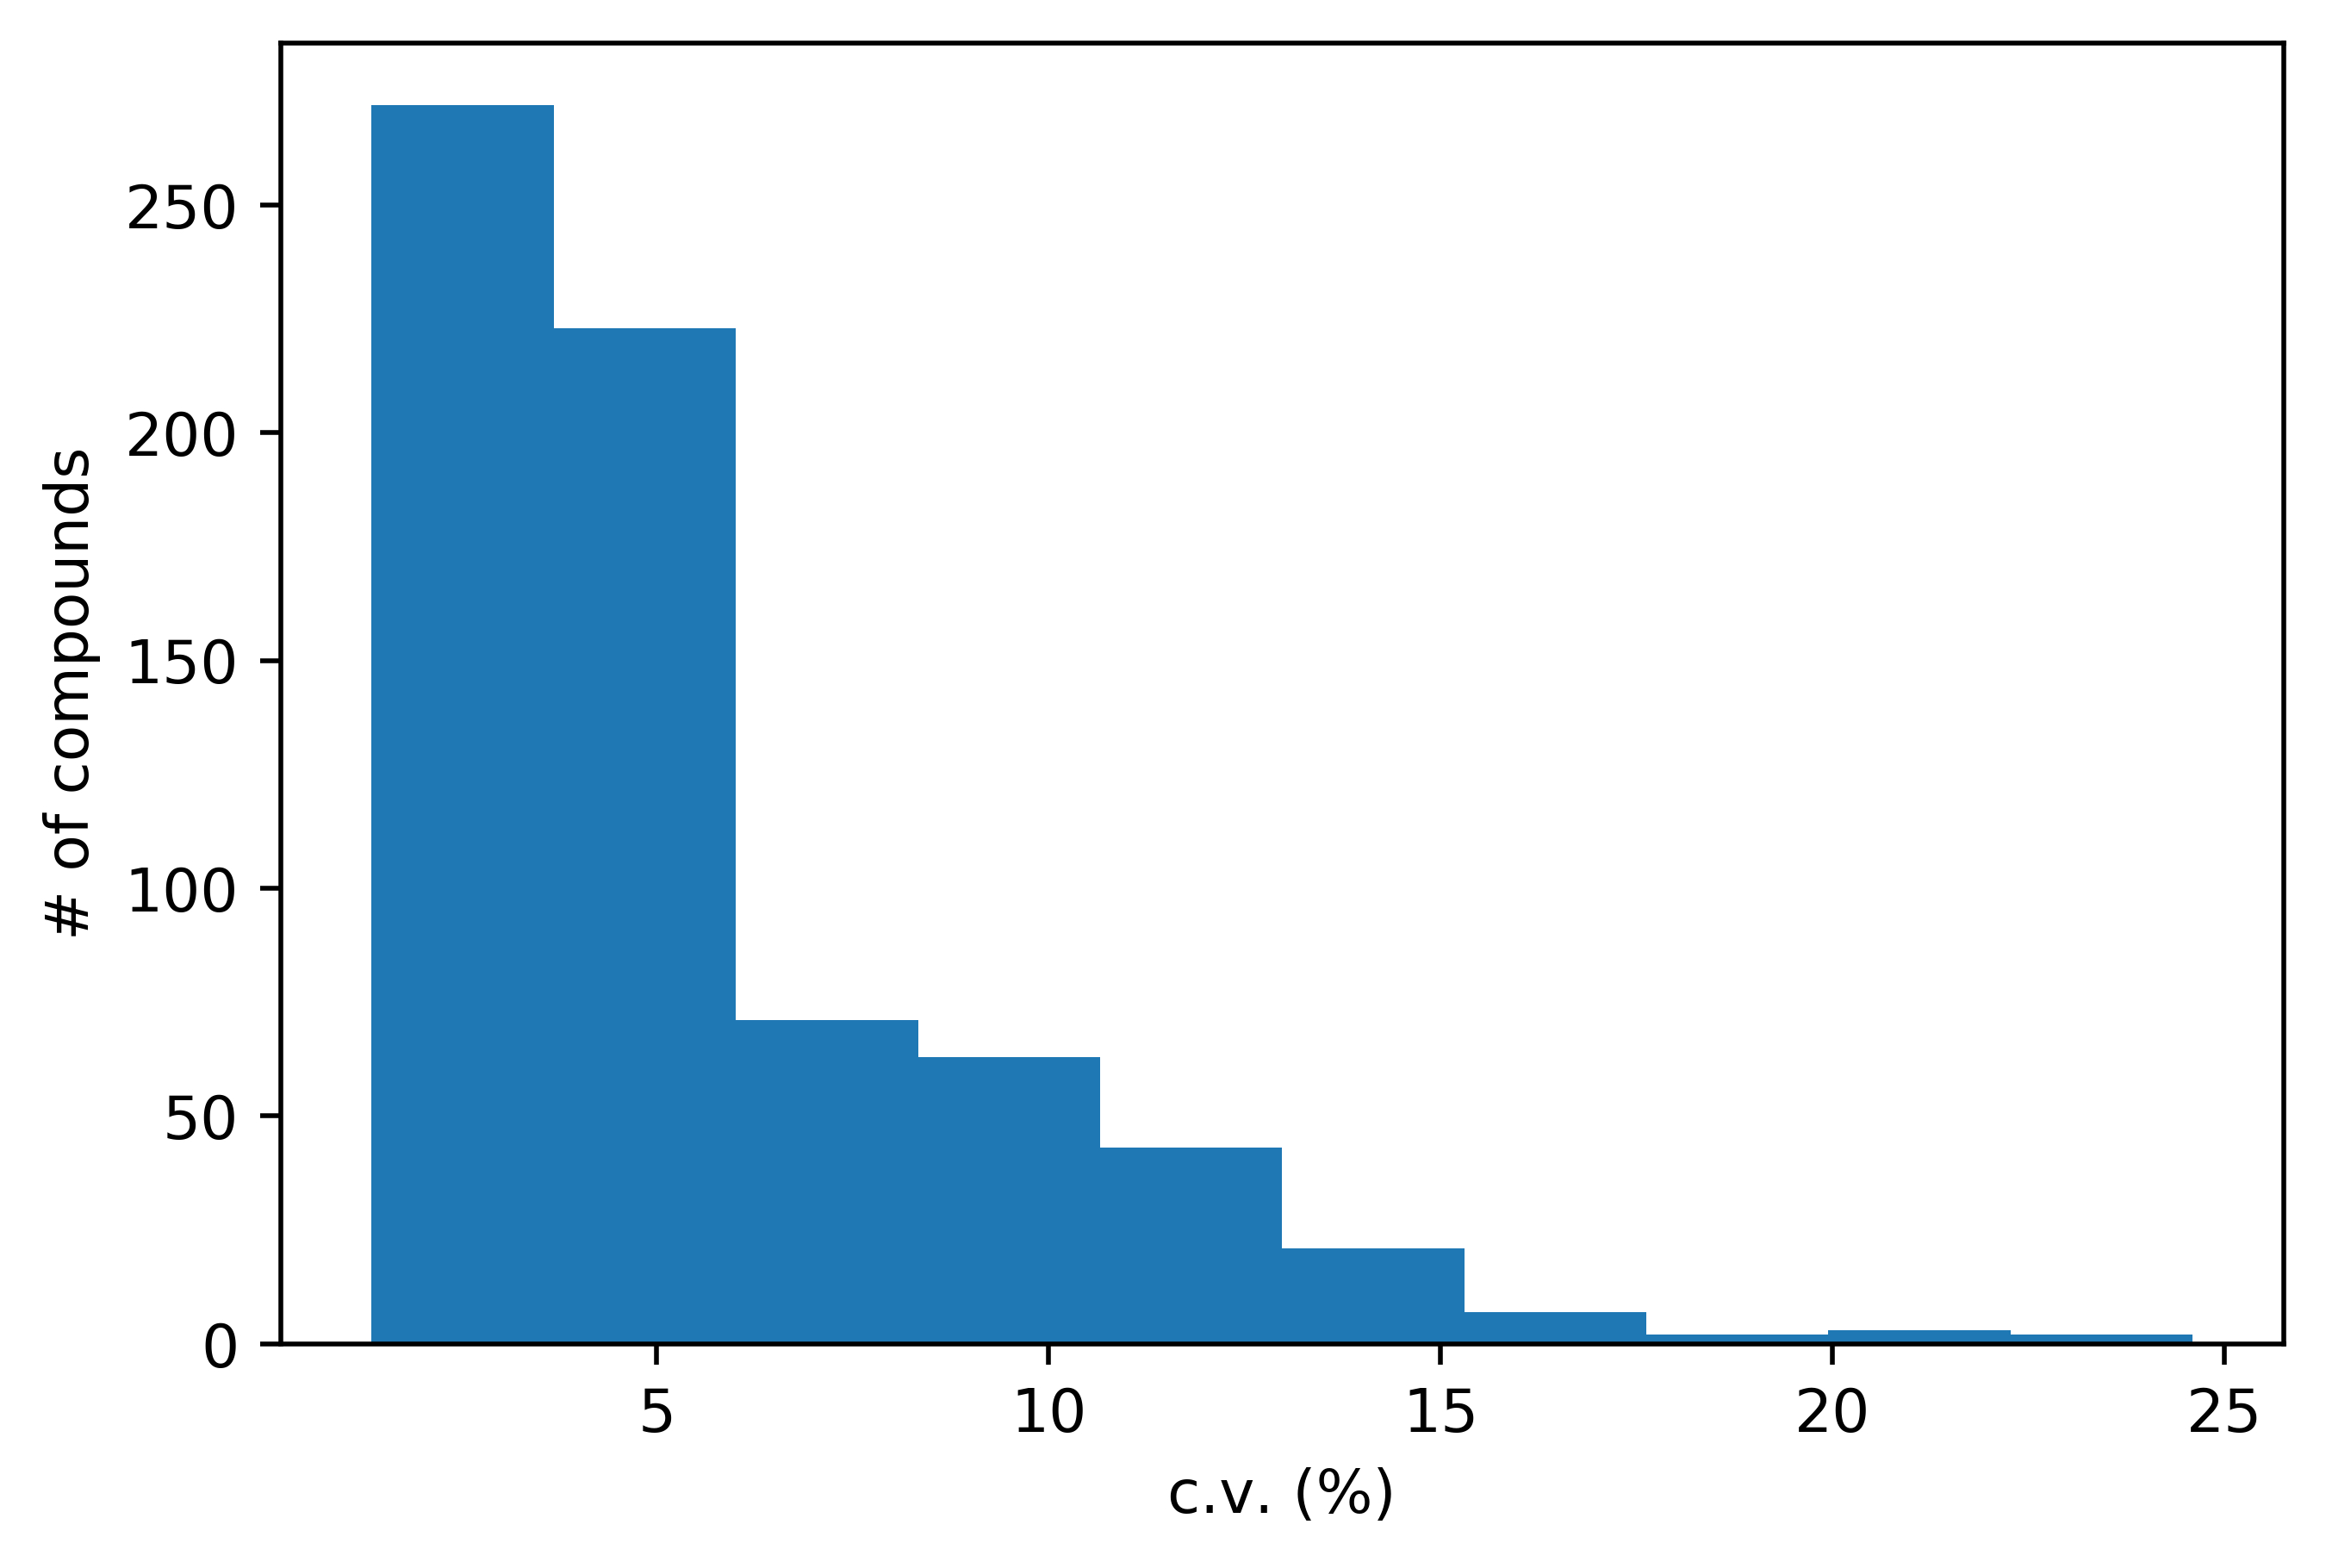

In [59]:
#plot cvs
d_rel = np.power(2,d_whole_imput[[x for x in range(len(samp_type)) if samp_type[x] == 0],:])
d_rel = d_whole_imput[[x for x in range(len(samp_type)) if samp_type[x] == 0],:]

cvs = [np.std(d_rel[:,x])/np.abs(np.mean(d_rel[:,x])) for x in range(len(d_rel[0]))]
plt.hist(100*np.array(cvs))
cutoffs = [.02,0.05,.1,.15]
old = 0
for x in cutoffs:
    per = len([m for m in cvs if m < x])
    print(x,per-old,len(cvs)-per)
    old = per
print(len(cvs))
plt.xlabel("c.v. (%)")
plt.ylabel("# of compounds")


found 9 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
No handles with labels found to put in legend.


Adjusting data


Text(0, 0.5, 'PC2')

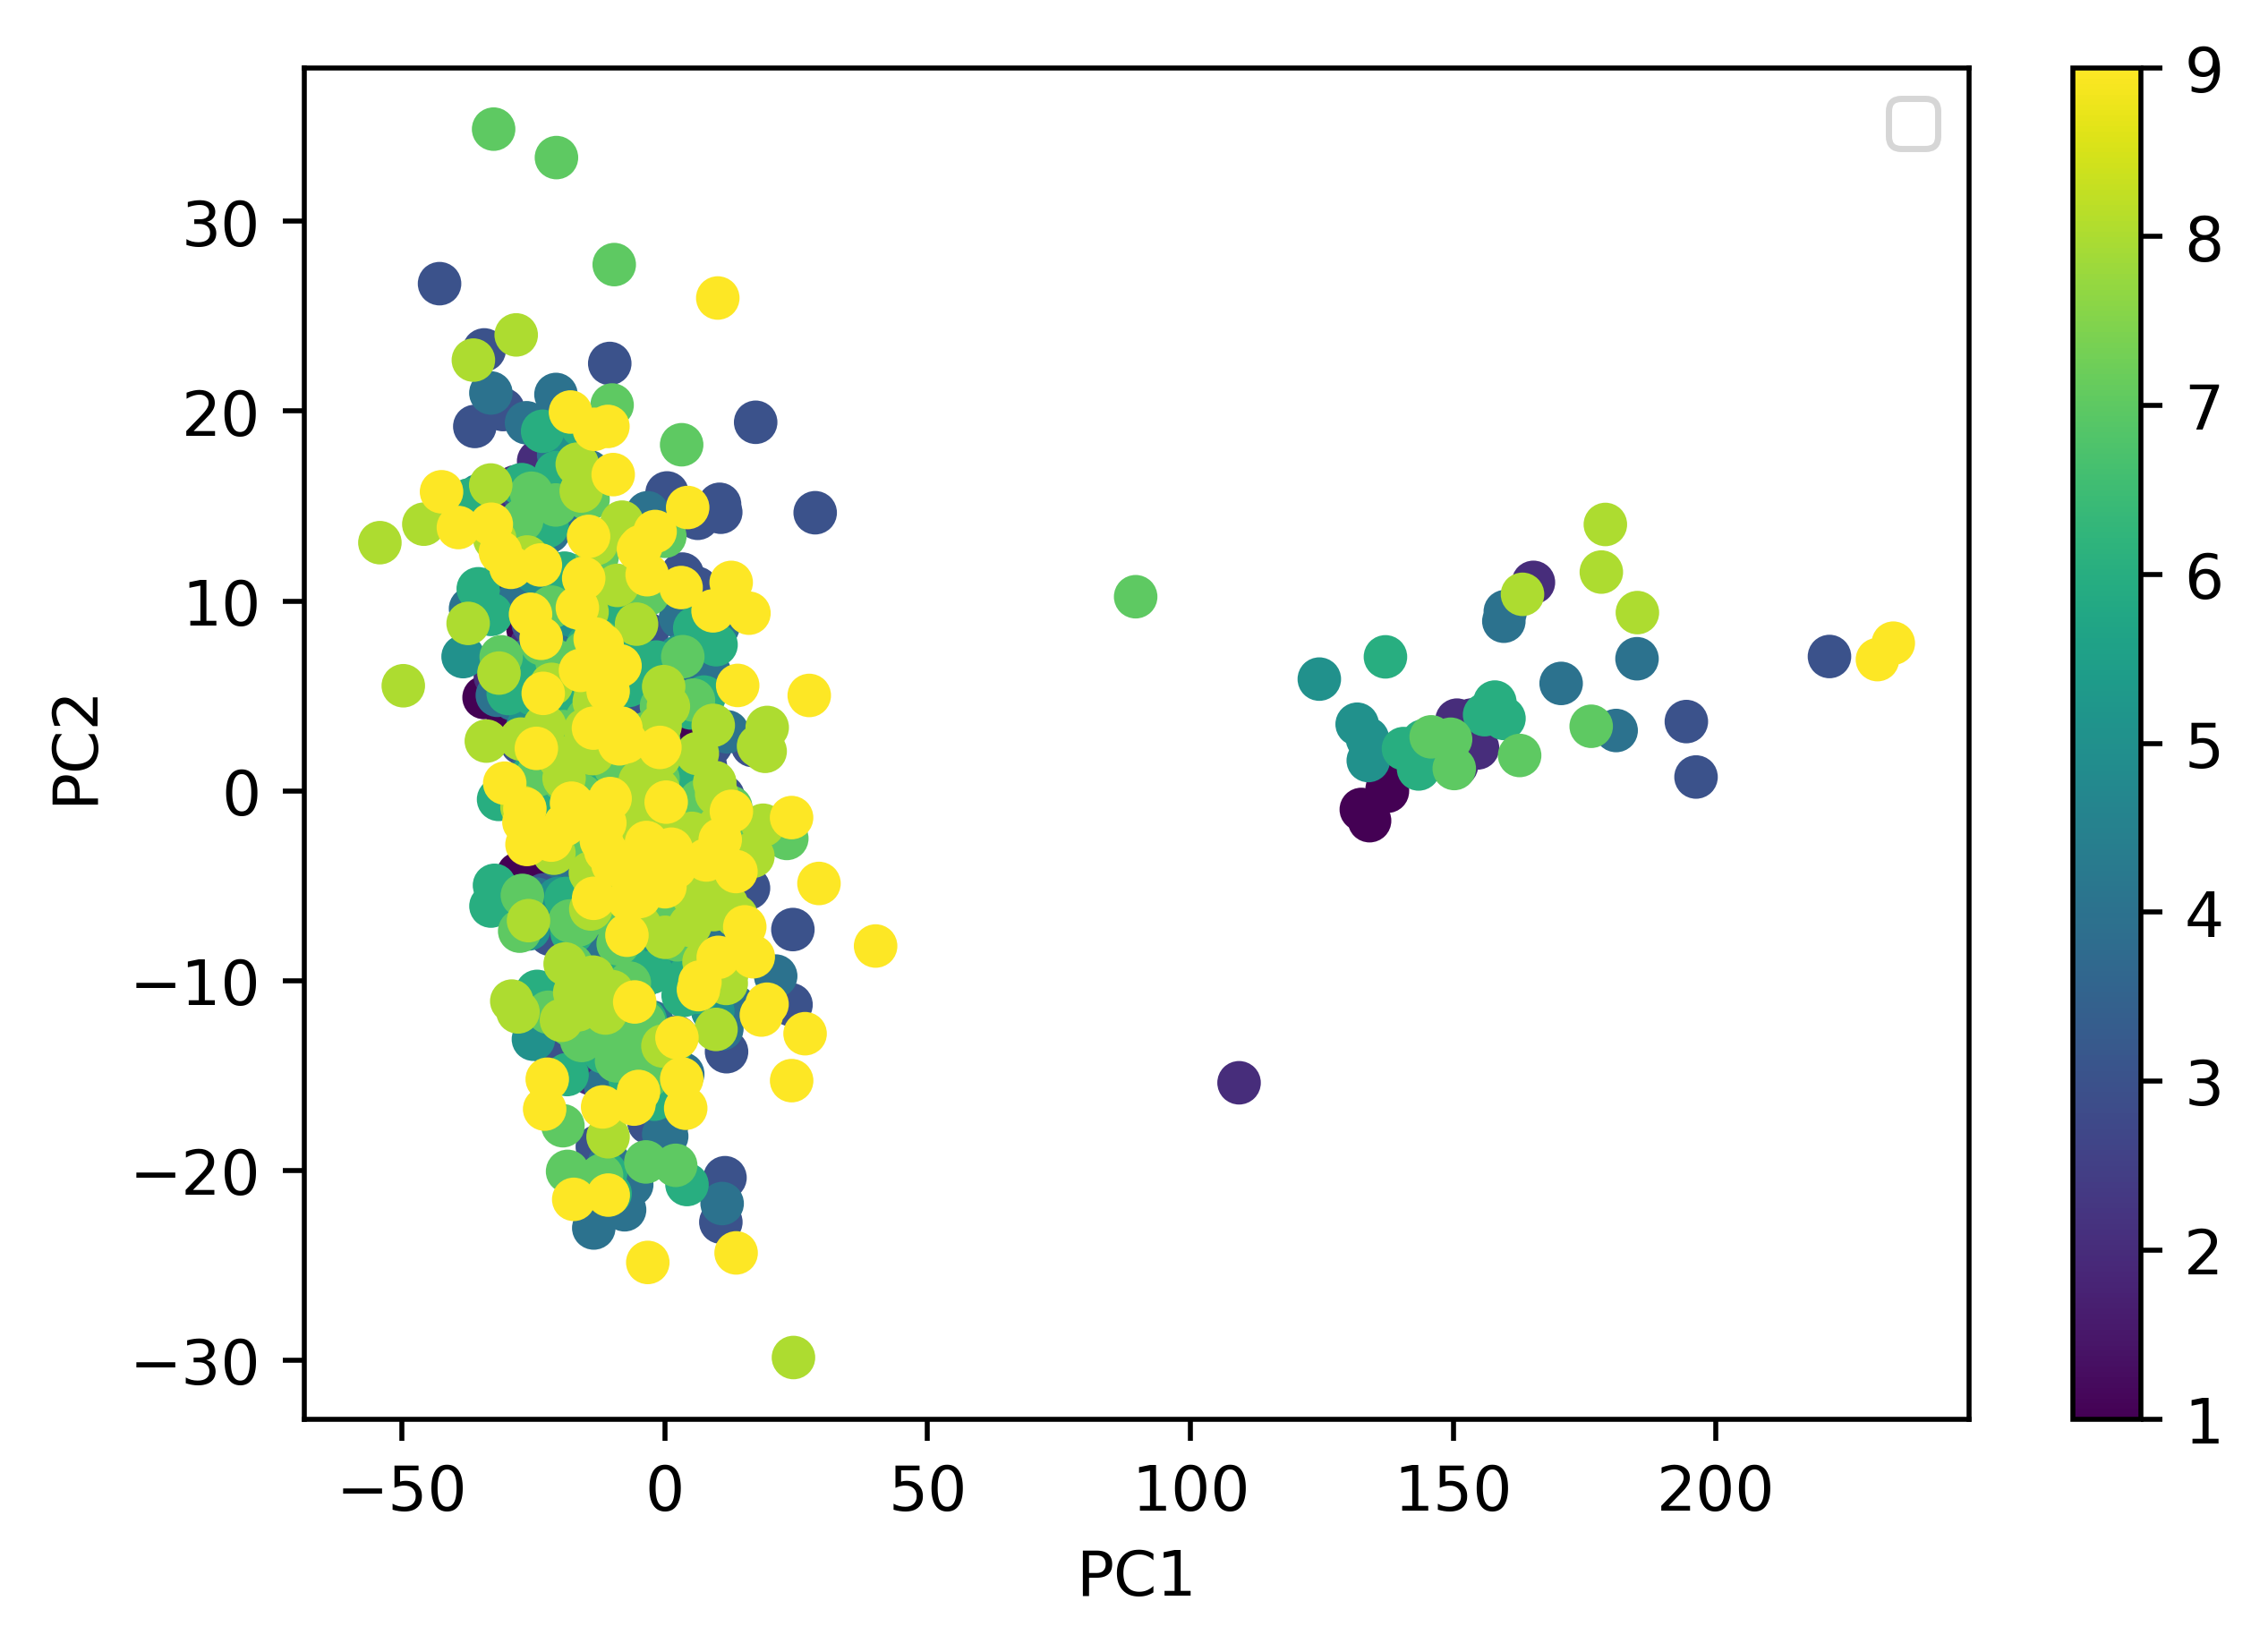

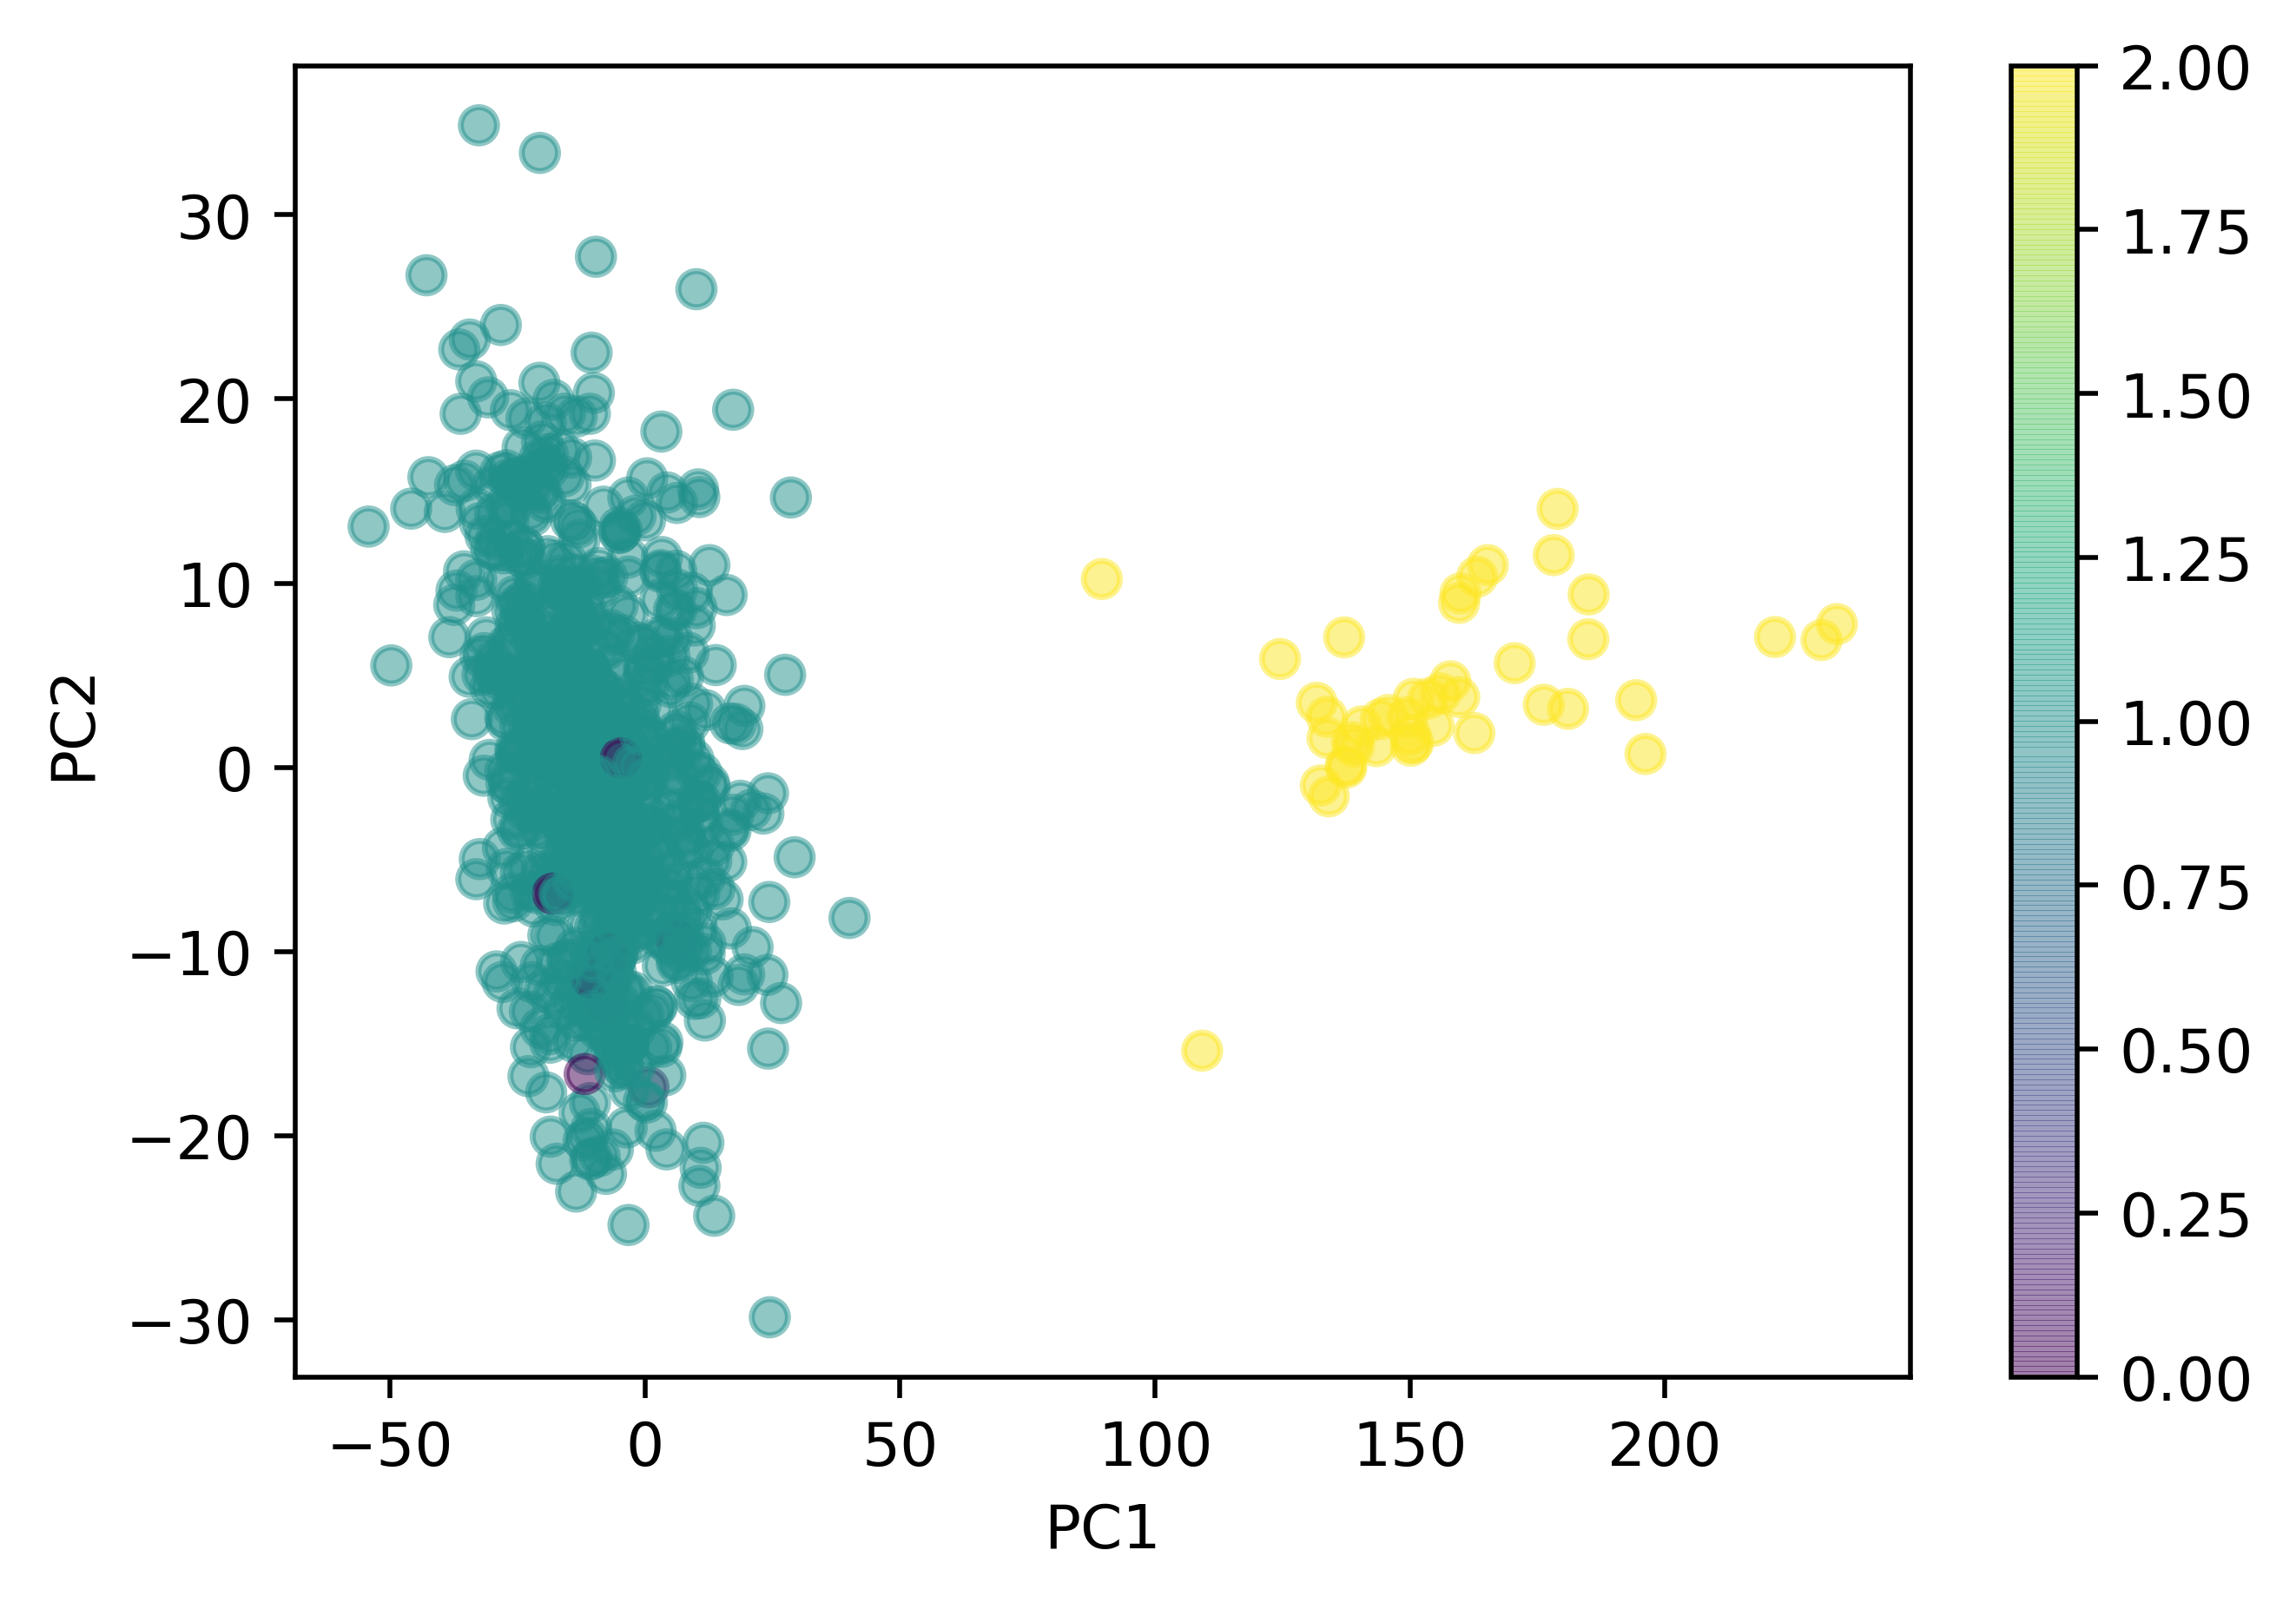

In [60]:
#now quantile normalize

d_whole_norm = combat.combat(pd.DataFrame(d_whole_imput.transpose()),batchInfo).transpose().to_numpy()

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

#make pca plot by batch
plt.figure()
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
plt.scatter(loads[:,0],loads[:,1],c=samp_type,alpha=.5)
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")



In [7]:
data[areaCols] = np.power(2,d_whole_norm.transpose())
data.to_csv(datafilename.replace(".csv","_normalized.csv"))

9
0.02 208 499
0.05 359 140
0.1 86 54
0.15 52 2
707


Text(0, 0.5, '# of compounds')

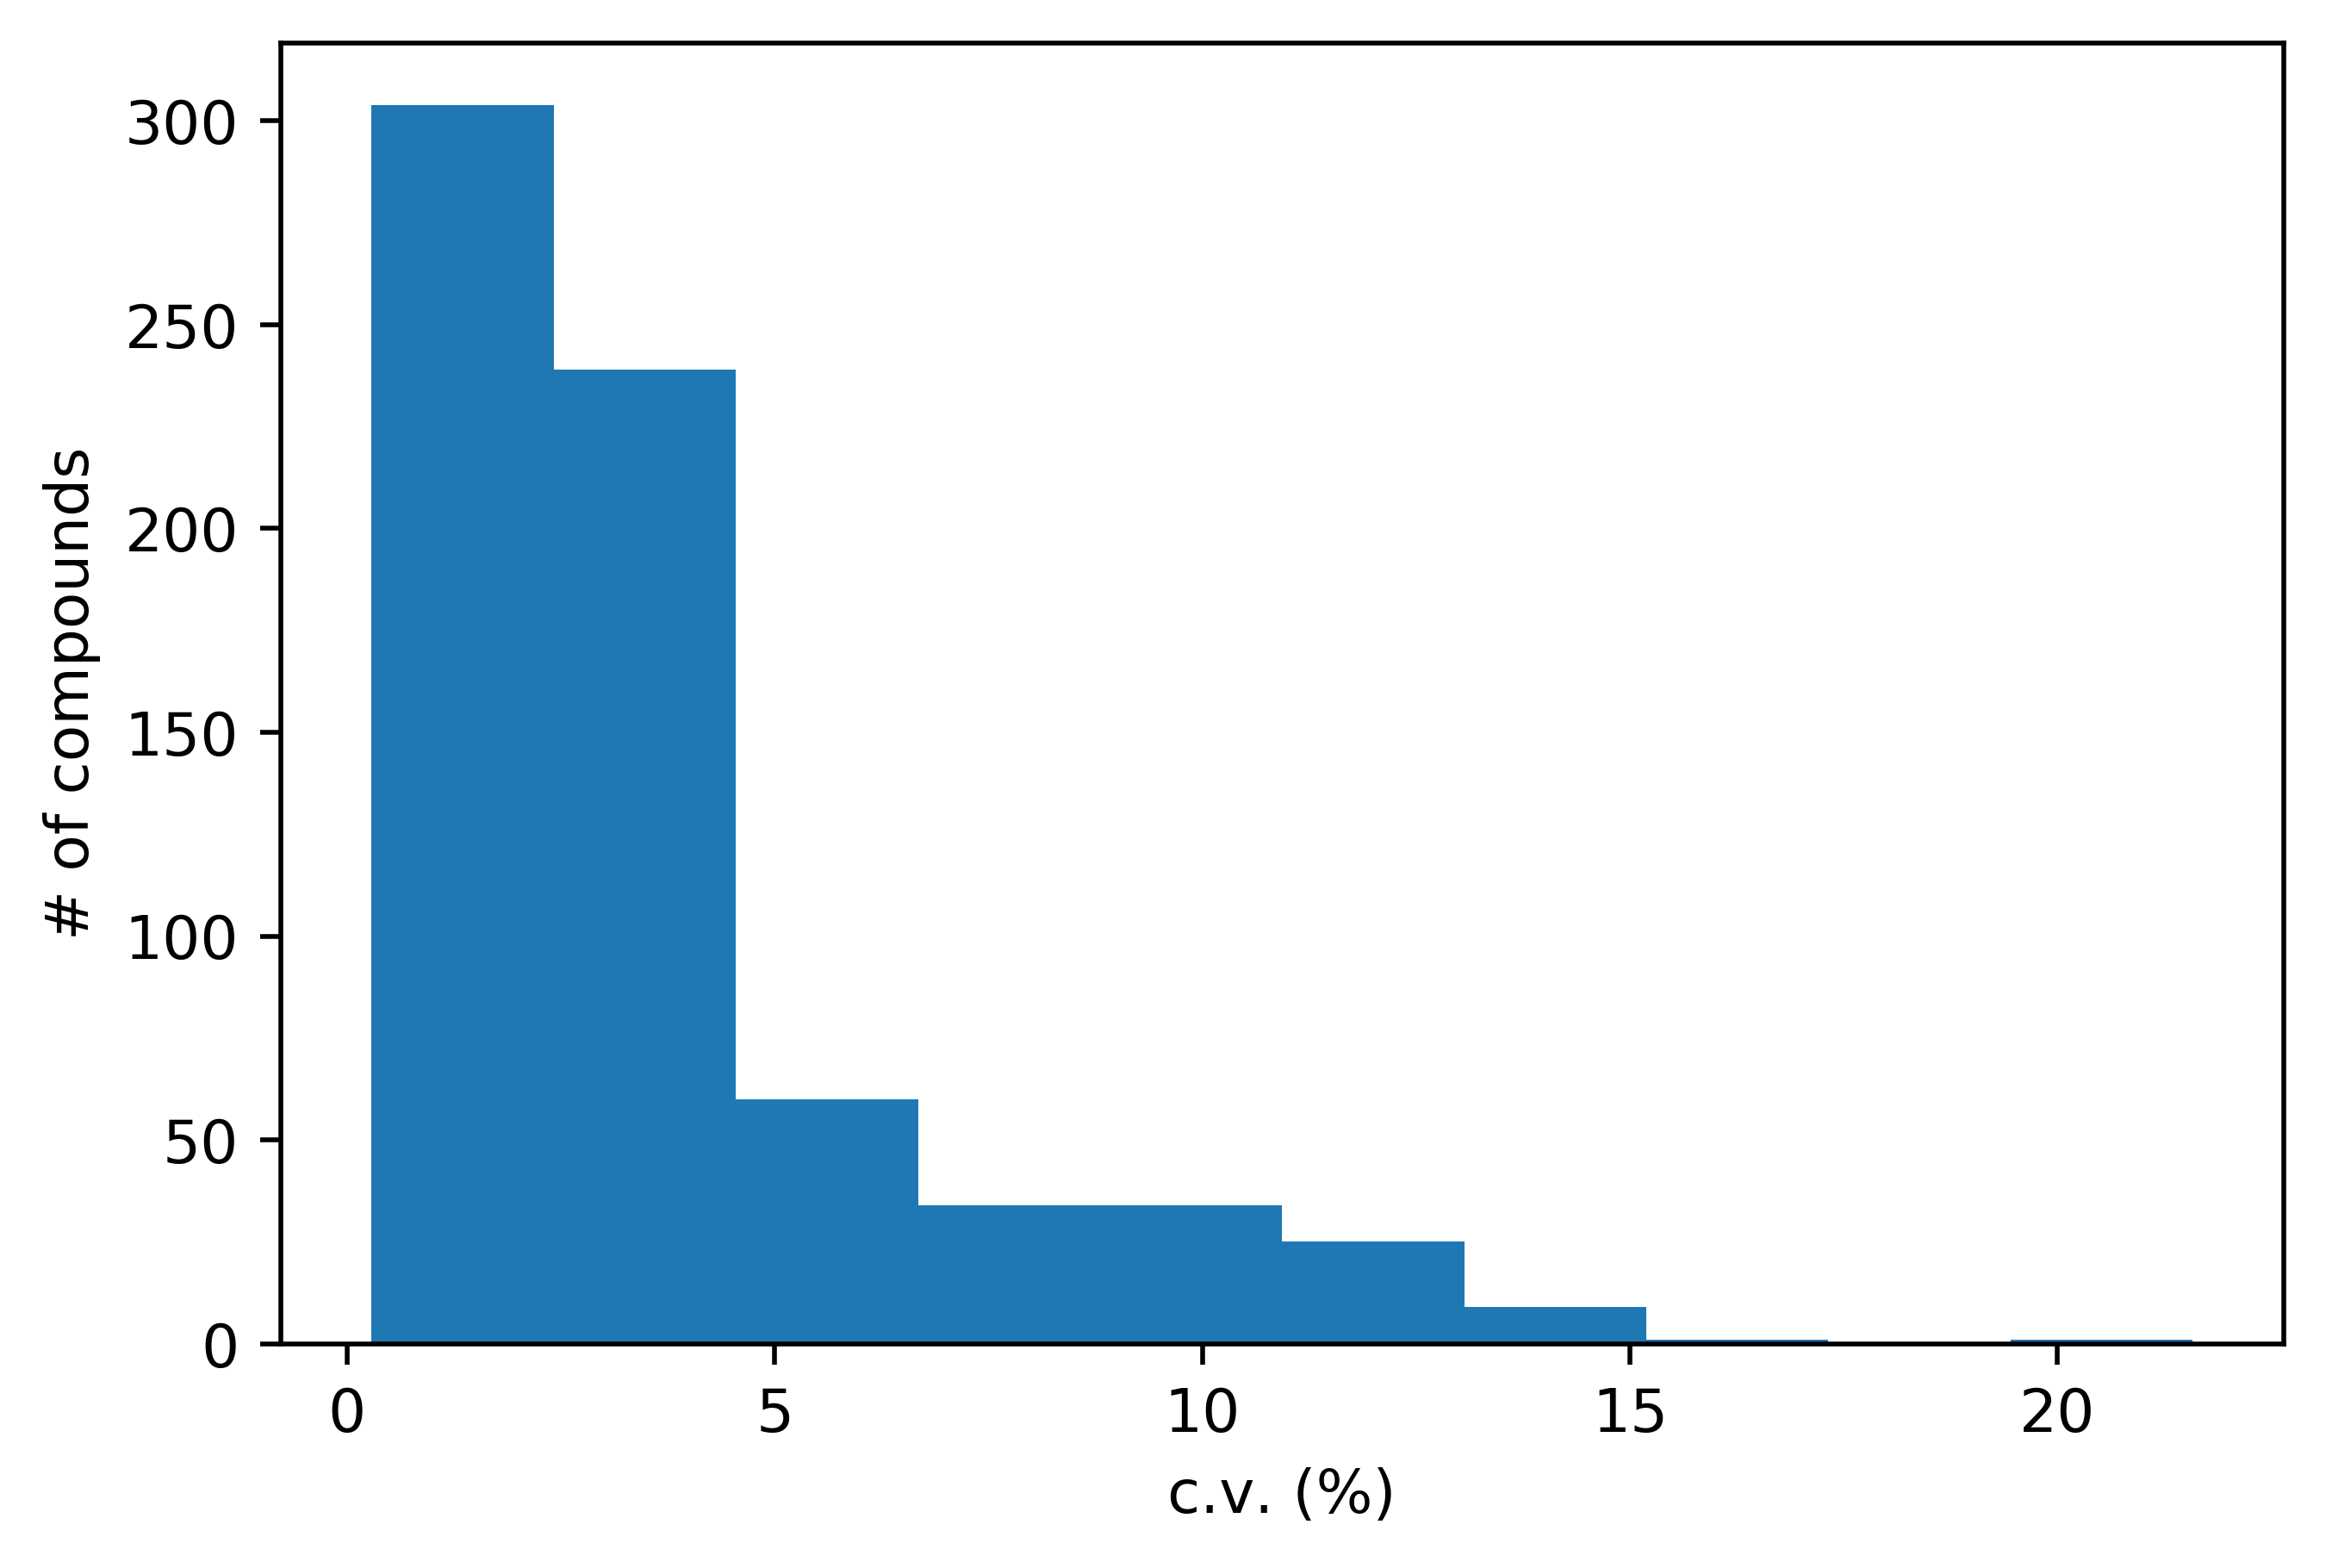

In [61]:
#plot cvs
#d_rel = np.power(2,d_whole_norm[[x for x in range(len(samp_type)) if samp_type[x] == 0],:])
d_rel = d_whole_norm[[x for x in range(len(samp_type)) if samp_type[x] == 0],:]

print(len(d_rel))
cvs = [np.std(d_rel[:,x])/np.abs(np.mean(d_rel[:,x])) for x in range(len(d_rel[0]))]
plt.hist(100*np.array(cvs))
cutoffs = [.02,0.05,.1,.15]
old = 0
for x in cutoffs:
    per = len([m for m in cvs if m < x])
    print(x,per-old,len(cvs)-per)
    old = per
print(len(cvs))
plt.xlabel("c.v. (%)")
plt.ylabel("# of compounds")

In [6]:
#write normalized data
